In [136]:
import json
from datetime import datetime, timedelta
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.sql.window import Window

import matplotlib.pyplot as plt
import requests
import os

os.environ["PYARROW_IGNORE_TIMEZONE"] = "1"

WORK_DIR = os.getcwd()
spark = SparkSession.builder.appName("TaxiDataAnalysis").config("spark.driver.host", "127.0.0.1").getOrCreate()
ride_df = spark.read.parquet(f'file:///{WORK_DIR}/yellow_taxi.parquet')

# Data Cleaning and Transformation
ride_df = ride_df.dropna()  # 결측치 제거

# 음수 값 필터링
ride_df = ride_df.filter(
    (col("trip_distance") > 0) &
    (col("fare_amount") > 0) &
    (col("total_amount") > 0) &
    (col("passenger_count") > 0)
)

# 의미 없는 컬럼 삭제
ride_df = ride_df.drop("VendorID", "RatecodeID", "store_and_fwd_flag,", "PULocationID", "DOLocationID", "payment_type")

# 여행 시간 계산 (분 단위)
ride_df = ride_df.withColumn(
    "trip_duration_minutes",
    (unix_timestamp(col("tpep_dropoff_datetime")) - unix_timestamp(col("tpep_pickup_datetime"))) / 60
)

# Metrics Calculation
metrics = ride_df.agg(
    avg("trip_duration_minutes").alias("avg_trip_duration"),
    avg("trip_distance").alias("avg_trip_distance")
)

metrics.show()

+------------------+-----------------+
| avg_trip_duration|avg_trip_distance|
+------------------+-----------------+
|15.763545132636214|3.302459328035664|
+------------------+-----------------+



In [137]:
# Peak Hours Analysis
hourly_trips = ride_df.groupBy(hour("tpep_pickup_datetime").alias("hour")) \
    .agg(count("*").alias("trip_count")) \
    .orderBy("hour")

hourly_trips.show()

+----+----------+
|hour|trip_count|
+----+----------+
|   0|     69189|
|   1|     45376|
|   2|     31932|
|   3|     20549|
|   4|     12783|
|   5|     15629|
|   6|     35583|
|   7|     74314|
|   8|    105119|
|   9|    119392|
|  10|    130036|
|  11|    141260|
|  12|    153606|
|  13|    159088|
|  14|    171274|
|  15|    176971|
|  16|    178411|
|  17|    191258|
|  18|    195918|
|  19|    170588|
+----+----------+
only showing top 20 rows



In [138]:
# 결과 저장
metrics.write.csv(f"file:///{WORK_DIR}/metrics.csv",
                  header=True, mode='overwrite')
hourly_trips.write.csv(
    f"file:///{WORK_DIR}/hourly_trips.csv", header=True, mode='overwrite')

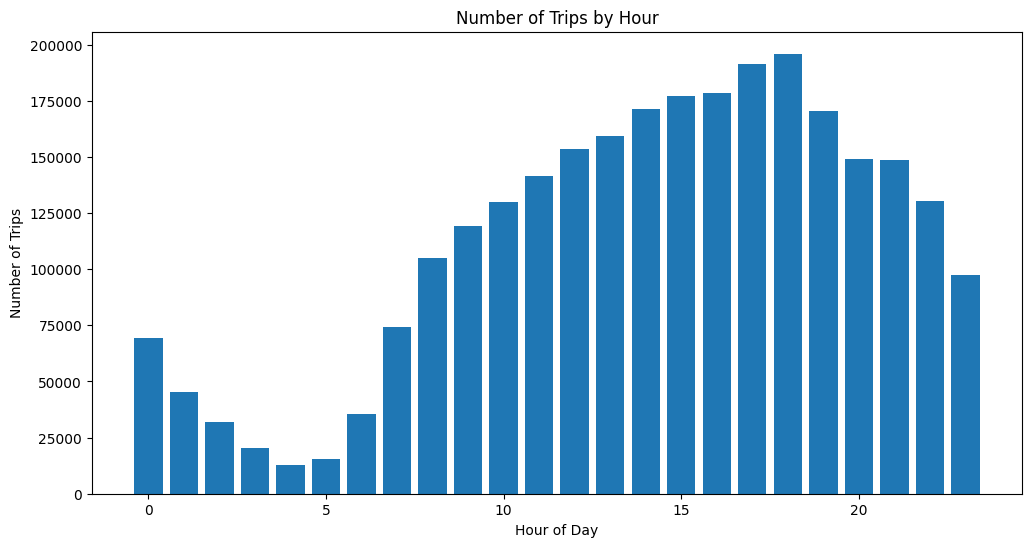

In [139]:
# 시각화
hourly_trips_pd = hourly_trips.toPandas()
plt.figure(figsize=(12, 6))
plt.bar(hourly_trips_pd["hour"], hourly_trips_pd["trip_count"])
plt.title("Number of Trips by Hour")
plt.xlabel("Hour of Day")
plt.ylabel("Number of Trips")
plt.savefig(f"{WORK_DIR}/hourly_trips.png")
plt.show()

In [140]:
def fetch_weather_data(date):
    url = f"https://www.timeanddate.com/scripts/cityajax.php?n=usa/new-york&mode=historic&hd={date}&month={date[4:6]}&year={date[:4]}&json=1"
    headers = {
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/92.0.4515.159 Safari/537.36",
        "Accept-Language": "en-US,en;q=0.5"
    }

    response = requests.get(url, headers=headers).text.replace("c:", "\"c\":").replace("s:", "\"s\":").replace("h:",
                                                                                                               "\"h\":")
    data = json.loads(response)
    weather_data = []
    for entry in data:
        row = {'time': entry['c'][0]['h'][:5], 'temperature(°C)': entry['c'][2]['h'].replace("&nbsp;°C", "").strip(),
               'description': entry['c'][3]['h'], 'wind_speed(km/h)': entry['c'][4]['h'].replace("km/h", "").strip(),
               'humidity(%)': entry['c'][6]['h'].replace("%", "").strip(),
               'barometer(mbar)': entry['c'][7]['h'].replace("mbar", "").strip(),
               'visibility(km)': entry['c'][8]['h'].replace("&nbsp;km", "").strip()}
        weather_data.append(row)

    # Convert list of dictionaries to DataFrame
    df = spark.createDataFrame(weather_data)
    df.write.csv(f'./weather/{date}', header=True, mode='overwrite')
    print(f"{date} weather data saved")
    return weather_data


def collect_weather_data(start_date, end_date):
    all_data = []
    current_date = start_date
    while current_date <= end_date:
        date_str = current_date.strftime('%Y%m%d')
        data = fetch_weather_data(date_str)
        all_data.extend(data)
        current_date += timedelta(days=1)
    return all_data


start_date = datetime(2024, 1, 1)
end_date = datetime(2024, 1, 31)
all_data = collect_weather_data(start_date, end_date)

20240101 weather data saved
20240102 weather data saved
20240103 weather data saved
20240104 weather data saved
20240105 weather data saved
20240106 weather data saved
20240107 weather data saved
20240108 weather data saved
20240109 weather data saved
20240110 weather data saved
20240111 weather data saved
20240112 weather data saved
20240113 weather data saved
20240114 weather data saved
20240115 weather data saved
20240116 weather data saved
20240117 weather data saved
20240118 weather data saved
20240119 weather data saved
20240120 weather data saved
20240121 weather data saved
20240122 weather data saved
20240123 weather data saved
20240124 weather data saved
20240125 weather data saved
20240126 weather data saved
20240127 weather data saved
20240128 weather data saved
20240129 weather data saved
20240130 weather data saved
20240131 weather data saved


In [141]:
# 1. 날씨 데이터를 로드하고 택시 데이터와 시간을 기준으로 조인
def read_weather_data(start_date, end_date):
    unioned = spark.read.csv(f'file:///{WORK_DIR}/weather/{start_date.strftime('%Y%m%d')}', header='true')
    unioned = unioned.withColumn("datetime",
                                 to_timestamp(concat(lit(f"{start_date.strftime('%Y-%m-%d')} "), col("time")),
                                              "yyyy-MM-dd HH:mm"))
    current_date = start_date + timedelta(days=1)
    while current_date <= end_date:
        date_str = current_date.strftime('%Y%m%d')
        weather_df = spark.read.csv(f'file:///{WORK_DIR}/weather/{date_str}', header='true')
        weather_df = weather_df.withColumn("datetime", to_timestamp(
            concat(lit(f"{current_date.strftime('%Y-%m-%d')} "), col("time")), "yyyy-MM-dd HH:mm"))
        unioned = unioned.union(weather_df)
        current_date += timedelta(days=1)
    unioned.orderBy(col("datetime"))
    return unioned


def join_weather_ride(weather_df, ride_df):
    # 윈도우 정의
    window_spec = Window.orderBy("datetime")
    # 이전 및 다음 행의 datetime 값 가져오기
    weather_df = weather_df.withColumn("prev_datetime", lag("datetime").over(window_spec)) \
        .withColumn("next_datetime", lead("datetime").over(window_spec))
    # 중간 시각 계산
    weather_df = weather_df.withColumn("start", expr(
        "CASE WHEN prev_datetime IS NOT NULL THEN (prev_datetime + (datetime - prev_datetime) / 2) ELSE datetime END")) \
        .withColumn("end", expr(
        "CASE WHEN next_datetime IS NOT NULL THEN (datetime + (next_datetime - datetime) / 2) ELSE datetime END")) \
        .drop("prev_datetime", "next_datetime", "time")
    # 탑승 시간 형식 변환
    ride_df = ride_df.withColumn("tpep_pickup_datetime",
                                 to_timestamp(col("tpep_pickup_datetime"), "yyyy-MM-dd HH:mm:ss.SSSSSS")) \
        .withColumn("tpep_dropoff_datetime",
                    to_timestamp(col("tpep_dropoff_datetime"), "yyyy-MM-dd HH:mm:ss.SSSSSS"))
    # 탑승 데이터와 날씨 데이터를 시간에 따라 조인
    joined_df = ride_df.join(weather_df,
                             (ride_df["tpep_pickup_datetime"] >= weather_df["start"]) &
                             (ride_df["tpep_pickup_datetime"] < weather_df["end"]),
                             how="left")
    return joined_df


weather_df = read_weather_data(start_date, end_date)
joined_df = join_weather_ride(weather_df, ride_df)


In [142]:
# 데이터 타입 변환
joined_df = joined_df.withColumn("tpep_pickup_datetime", col("tpep_pickup_datetime").cast(TimestampType())) \
    .withColumn("tpep_dropoff_datetime", col("tpep_dropoff_datetime").cast(TimestampType())) \
    .withColumn("passenger_count", col("passenger_count").cast(IntegerType())) \
    .withColumn("trip_distance", col("trip_distance").cast(DoubleType())) \
    .withColumn("store_and_fwd_flag", col("store_and_fwd_flag").cast(StringType())) \
    .withColumn("fare_amount", col("fare_amount").cast(DoubleType())) \
    .withColumn("extra", col("extra").cast(DoubleType())) \
    .withColumn("mta_tax", col("mta_tax").cast(DoubleType())) \
    .withColumn("tip_amount", col("tip_amount").cast(DoubleType())) \
    .withColumn("tolls_amount", col("tolls_amount").cast(DoubleType())) \
    .withColumn("improvement_surcharge", col("improvement_surcharge").cast(DoubleType())) \
    .withColumn("total_amount", col("total_amount").cast(DoubleType())) \
    .withColumn("congestion_surcharge", col("congestion_surcharge").cast(DoubleType())) \
    .withColumn("Airport_fee", col("Airport_fee").cast(DoubleType())) \
    .withColumn("trip_duration_minutes", col("trip_duration_minutes").cast(DoubleType())) \
    .withColumn("barometer(mbar)", col("barometer(mbar)").cast(DoubleType())) \
    .withColumn("description", col("description").cast(StringType())) \
    .withColumn("humidity(%)", col("humidity(%)").cast(IntegerType())) \
    .withColumn("temperature(°C)", col("temperature(°C)").cast(DoubleType())) \
    .withColumn("visibility(km)", col("visibility(km)").cast(DoubleType())) \
    .withColumn("wind_speed(km/h)", col("wind_speed(km/h)").cast(DoubleType())) \
    .withColumn("datetime", col("datetime").cast(TimestampType())) \
    .withColumn("start", col("start").cast(TimestampType())) \
    .withColumn("end", col("end").cast(TimestampType()))

weather_df.write.csv(f'./weather/January', header=True, mode='overwrite')
joined_df.write.csv(f'./joined/January', header=True, mode='overwrite')

24/07/25 16:10:16 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/07/25 16:10:16 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/07/25 16:10:17 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/07/25 16:10:17 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


In [143]:
# 날씨와 요금 간의 상관관계 분석
correlation = joined_df.select(corr("total_amount", "temperature(°C)").alias("correlation")).collect()[0]["correlation"]
print(f"Correlation between total amount and temperature: {correlation}")

24/07/25 16:10:28 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/07/25 16:10:28 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/07/25 16:10:28 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/07/25 16:10:28 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


Correlation between total amount and temperature: -0.002573051214248782


In [144]:
# 1. 날씨 데이터를 로드하고 택시 데이터와 시간을 기준으로 조인
# 2. 날씨 조건(예: 온도, 강수량)과 여행 수 간의 상관관계 분석
# 3. 날씨 조건에 따른 여행 수 변화를 시각화

# 각 날씨 조건별로 여행 수 계산
weather_trip_counts = joined_df.groupBy("temperature(°C)", "description").agg(
    count("tpep_pickup_datetime").alias("trip_count"))
weather_trip_counts.show()
# 상관관계 분석
correlation_temp_trip_count = \
    weather_trip_counts.select(corr("temperature(°C)", "trip_count").alias("correlation")).collect()[0]["correlation"]
print(f"Correlation between temperature and trip count: {correlation_temp_trip_count}")

24/07/25 16:10:33 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/07/25 16:10:33 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/07/25 16:10:34 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/07/25 16:10:34 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/07/25 16:10:38 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/07/25 16:10:38 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


+---------------+--------------------+----------+
|temperature(°C)|         description|trip_count|
+---------------+--------------------+----------+
|            3.0|         Low clouds.|      8845|
|            3.0|              Clear.|     48074|
|            4.0|              Sunny.|      1194|
|           13.0|     Passing clouds.|      2301|
|            6.0|Light rain. Mostl...|      5513|
|            7.0|           Overcast.|     59027|
|            7.0|Light rain. Overc...|       167|
|           11.0|    Light rain. Fog.|     40281|
|           12.0|    Heavy rain. Fog.|      4182|
|           14.0|Light rain. Partl...|      1969|
|            3.0|More clouds than ...|      1026|
|            8.0|           Overcast.|     41162|
|           16.0|   Scattered clouds.|      2156|
|            3.0|Light rain. Overc...|     18673|
|           13.0|      Mostly cloudy.|     12143|
|            3.0|Light rain. Low c...|      1407|
|            1.0|    Light snow. Fog.|      2596|


24/07/25 16:10:38 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/07/25 16:10:38 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


Correlation between temperature and trip count: -0.13972360493578992


24/07/25 16:10:42 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/07/25 16:10:42 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/07/25 16:10:42 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/07/25 16:10:42 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


<Axes: xlabel='temperature(°C)'>

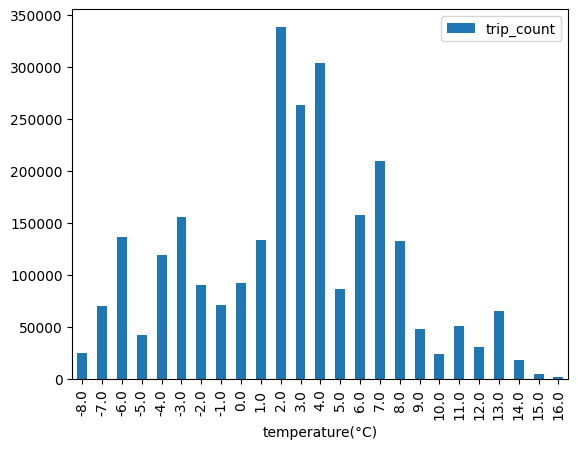

In [145]:
pandas_df = weather_trip_counts.toPandas().dropna()
pandas_df["temperature(°C)"] = pandas_df["temperature(°C)"].astype(float)
pandas_df.groupby("temperature(°C)").sum("trip_count").sort_values(by="temperature(°C)").plot(kind='bar')

In [146]:
# SparkSession 종료
spark.stop()